In [1]:
import numpy as np
import pandas as pd
import sys
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn
import lazypredict
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
import itertools
from sklearn.impute import KNNImputer
import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-g3zq5gba because the default path (/home/determined_keller/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
df_train = pd.read_csv('../DATA/train_airbnb_berlin.xls')

# without label
#df_validation = pd.read_csv('./test_airbnb_berlin.xls') 

# Pre processing

### Feature analysis

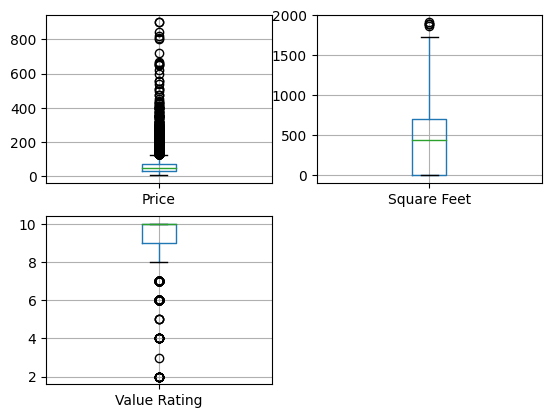

In [3]:
plt.subplot(221)
df_train.boxplot(column='Price')

plt.subplot(222)
df_train.boxplot(column='Square Feet')

plt.subplot(223)
df_train.boxplot(column='Value Rating')

plt.show()

In [4]:
def percentage_of_nans(df: pd.DataFrame) -> list:
    nan_percentage = pd.DataFrame(columns=['Feature Name', 'Percentage of NaNs'])
    for idx, feature in enumerate(df.columns):
        notnans = df_train[feature].notna().value_counts()
        percentage = 0
        if False in notnans:
            percentage = int(10000*notnans[False]/len(df_train))/100

        nan_percentage.loc[idx] = [feature, percentage]
    return nan_percentage

In [5]:
nan_percentage = percentage_of_nans(df_train)
df = nan_percentage[nan_percentage['Percentage of NaNs'] != 0]
df.sort_values(by=['Percentage of NaNs'], ascending=False)

,Feature Name,Percentage of NaNs
23,Square Feet,98.06
5,Host Response Time,45.08
6,Host Response Rate,45.08
32,Checkin Rating,18.94
35,Value Rating,18.93
34,Location Rating,18.93
30,Accuracy Rating,18.93
33,Communication Rating,18.92
31,Cleanliness Rating,18.92
29,Overall Rating,18.87


### Data cleaning

In [6]:

def replace_na(df : pd.DataFrame, numerical_variables : list()):
    df.replace(['f', 't'], [0, 1], inplace=True)
    df.replace(["*"], [np.NaN], inplace=True)
    
    imputer = KNNImputer(n_neighbors=3)
    imputed_values = imputer.fit_transform(df[numerical_variables])
    df[numerical_variables] = pd.DataFrame(imputed_values, columns=numerical_variables)

    return df

    
def pre_process(df : pd.DataFrame):

    numerical_variables = ['Latitude', 'Longitude', 'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Min Nights',\
        'Reviews']
    ratings = ['Accuracy Rating', 'Value Rating', 'Checkin Rating', 'Overall Rating', 'Location Rating', 'Communication Rating', 'Cleanliness Rating']
    numerical_variables += ratings

    categorical_variables = ['Room Type', 'Property Type']

    boolean_variables = ['Is Exact Location', 'Instant Bookable', 'Business Travel Ready']

    selected_columns = numerical_variables + categorical_variables + boolean_variables

    label_in = 'Price' in df.columns
    if label_in:
        selected_columns.append('Price')
    
    df = replace_na(df, numerical_variables)

    df = df[selected_columns]
    df.dropna(inplace=True)
    
    # categorcial to dummies
    for cat_var in categorical_variables:
        dummie = pd.get_dummies(df[cat_var])
        df = pd.concat([df, dummie], axis=1)

    #rescale the coordinates ?
    sklearn.preprocessing.minmax_scale(df['Latitude'], feature_range=(-10, 10), copy=False)
    sklearn.preprocessing.minmax_scale(df['Longitude'], feature_range=(-10, 10), copy=False)

    y = df['Price']
    df.drop(["Price", "Room Type", "Property Type"], axis=1, inplace=True)
    
    if(label_in):
        return df, y
    
    return df

In [7]:
X, y = pre_process(df_train)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# Feature analysis

### PCA

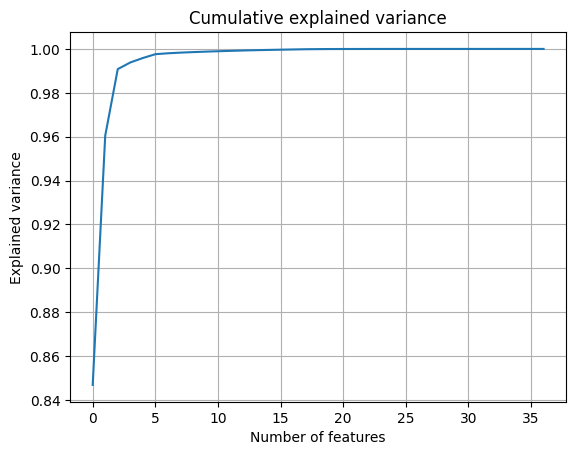

Explained variance with 5 features:  0.9958474393044456


In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_
acc_sum = np.cumsum(explained_variance) 

plt.title('Cumulative explained variance')
plt.plot(acc_sum)
plt.grid()
plt.ylabel('Explained variance')
plt.xlabel('Number of features')
plt.show()

print('Explained variance with 5 features: ', acc_sum[4])

### Forward selection + Cross Validation

In [ ]:
def fit_clf(clf, X, y, params):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    kf = KFold(n_splits=5)
    metric = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
    
        model_k = clf(**params)
        model_k.fit(X_train,y_train)
        metric.append(model_k.score(X_test,y_test))
    return np.array(metric).mean()

In [ ]:
def get_feature_importance(clf, params):
	r2 = [] 
	features = []
	n_features = []

	for k in range(1,len(X.columns) + 1):
		r2_tmp = []
		for new_feat in X_train.columns:
			if new_feat in features: continue
			new_features = features.copy()
			new_features.append(new_feat)
			r2_val = fit_clf(clf, X_train[new_features],y_train, params)   
			r2_tmp.append((r2_val, new_feat))                 
		r2.append(sorted(r2_tmp, key=lambda x: x[0])[-1][0])	
		new_feat = sorted(r2_tmp, key=lambda x: x[0])[-1][1]
		features.append(new_feat)
		n_features.append(len(features))   

	df = pd.DataFrame({'n_features': n_features,'R2': r2,'features':features})

	return df

In [ ]:
df = get_feature_importance(linear_model.LinearRegression, {})
plt.title('Cross-validated subset selection - Linear Regression')
plt.xlabel('Number of features')
plt.ylabel('R squared')
plt.grid()
plt.plot(df['n_features'], df['R2'])
plt.show()


### Autoencoder

In [114]:
from sklearn.neural_network import MLPRegressor

n_input = X_train.columns

n_encoder1 = 50
n_encoder2 = 30

n_latent = 2

n_decoder2 = 30
n_decoder1 = 50

In [115]:
reg = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1), 
                   activation = 'tanh', 
                   solver = 'adam', 
                   learning_rate_init = 1e-4, 
                   max_iter = 100, 
                   tol = 0.0000001, 
                   verbose = False)

In [116]:
reg.fit(X_train, y_train)

/home/josemelocosta/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='tanh', hidden_layer_sizes=(50, 30, 2, 30, 50),
             learning_rate_init=0.0001, max_iter=100, tol=1e-07)

In [117]:
def encoder(data):
    data = np.asmatrix(data)
    
    encoder1 = data*reg.coefs_[0] + reg.intercepts_[0]
    encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
    
    encoder2 = encoder1*reg.coefs_[1] + reg.intercepts_[1]
    encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
    
    latent = encoder2*reg.coefs_[2] + reg.intercepts_[2]
    latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
    
    return np.asarray(latent)

test_latent = encoder(X_train)


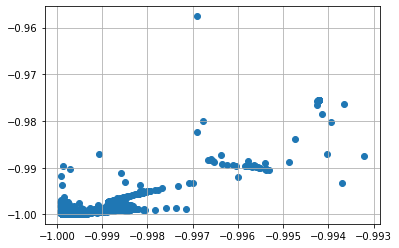

In [120]:
plt.scatter(test_latent[:, 0], test_latent[:, 1])
plt.grid()
plt.show()

# Model selection

### Decision Trees

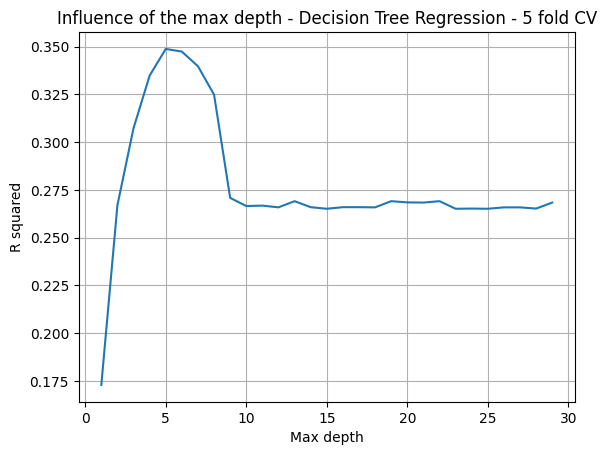

In [98]:
r2 = []
max_depth = []
for k in range(1, 30):
    r2_val = fit_clf(DecisionTreeRegressor, X_train[new_features],y_train, {"max_depth": k}) 
    r2.append(r2_val)	
    max_depth.append(k)

df = pd.DataFrame({'R2': r2,'max_depth':max_depth})
plt.title('Influence of the max depth - Decision Tree Regression - 5 fold CV')
plt.xlabel('Max depth')
plt.ylabel('R squared')
plt.grid()
plt.plot(df['max_depth'], df['R2'])
plt.show()

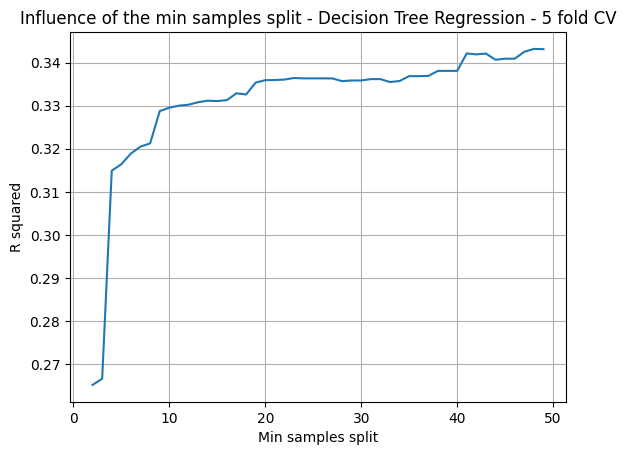

In [95]:
r2 = []
min_samples_split = []
for k in range(2, 50):
    r2_val = fit_clf(DecisionTreeRegressor, X_train[new_features],y_train, {"min_samples_split": k}) 
    r2.append(r2_val)	
    min_samples_split.append(k)

df = pd.DataFrame({'R2': r2,'min_samples_split':min_samples_split})
plt.title('Influence of the min samples split - Decision Tree Regression - 5 fold CV')
plt.xlabel('Min samples split')
plt.ylabel('R squared')
plt.grid()
plt.plot(df['min_samples_split'], df['R2'])
plt.show()

In [97]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':np.arange(1, 15), 'min_samples_split':np.arange(2, 5)}
clf = GridSearchCV(DecisionTreeRegressor(), parameters)
clf.fit(X_train, y_train)
print('Best params: ', clf.best_params_)
print('Best score: ', clf.best_score_)

Best params:  {'max_depth': 4, 'min_samples_split': 2}
Best score:  0.3336581268285735


### SVM

In [ ]:
def fit_clf_scaler(clf, X, y, params, n_features=10):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    kf = KFold(n_splits=5)
    metric = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
    
        pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=n_features)), ('svr', clf(**params))])
        pipe.fit(X_train,y_train)
        metric.append(pipe.score(X_test,y_test))
    return np.array(metric).mean()

In [16]:
from sklearn import svm
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def objective(trial: optuna.trial.Trial):

    parameters = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'C': trial.suggest_float('C', 1e-3, 1e3),
        'epsilon': trial.suggest_float('epsilon', 1e-3, 1)
    }

    clf = svm.SVR
    return -fit_clf_scaler(clf, X_train, y_train, parameters)

study = optuna.create_study()
study.optimize(objective, n_trials=1)


[I 2022-10-25 18:54:41,803] A new study created in memory with name: no-name-68da5127-3b3d-4499-8fc2-64539eb4b436
[I 2022-10-25 18:56:25,503] Trial 0 finished with value: -0.33741671800551337 and parameters: {'kernel': 'rbf', 'C': 595.6756199722245, 'epsilon': 0.8771538699650302}. Best is trial 0 with value: -0.33741671800551337.


### AdaBoost

In [14]:
from sklearn.ensemble import AdaBoostRegressor

def objective(trial: optuna.trial.Trial):

    parameters = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 200),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1)
    }

    clf = AdaBoostRegressor
    return -fit_clf(clf, X_train, y_train, parameters)

study = optuna.create_study()
study.optimize(objective, n_trials=10)


[I 2022-10-25 18:30:15,245] A new study created in memory with name: no-name-f76e2f3d-bcec-42cb-95ee-444f5c1d7e97
[I 2022-10-25 18:30:18,109] Trial 0 finished with value: 0.6103193194296334 and parameters: {'n_estimators': 63, 'learning_rate': 0.9042239661682658}. Best is trial 0 with value: 0.6103193194296334.
[I 2022-10-25 18:30:22,259] Trial 1 finished with value: 1.0749958135363609 and parameters: {'n_estimators': 64, 'learning_rate': 0.836955072932582}. Best is trial 0 with value: 0.6103193194296334.
[I 2022-10-25 18:30:39,759] Trial 2 finished with value: 0.020245007926715908 and parameters: {'n_estimators': 146, 'learning_rate': 0.08099420342293925}. Best is trial 2 with value: 0.020245007926715908.
[I 2022-10-25 18:30:58,365] Trial 3 finished with value: -0.018003378252936787 and parameters: {'n_estimators': 159, 'learning_rate': 0.06858222575321077}. Best is trial 3 with value: -0.018003378252936787.
[I 2022-10-25 18:30:59,348] Trial 4 finished with value: -0.2716588164078967 

### Gradient Tree Boosting

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

def objective(trial: optuna.trial.Trial):

    parameters = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 200),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 20)
    }

    clf = GradientBoostingRegressor
    return -fit_clf(clf, X_train, y_train, parameters)

study = optuna.create_study()
study.optimize(objective, n_trials=1)



[I 2022-10-25 19:00:08,891] A new study created in memory with name: no-name-68488f9f-7a1e-40ca-bbfc-e11c5a4c7a2e
[I 2022-10-25 19:00:46,355] Trial 0 finished with value: -0.18953959700993545 and parameters: {'n_estimators': 130, 'learning_rate': 0.3405134657476843, 'max_depth': 8}. Best is trial 0 with value: -0.18953959700993545.


### MLP

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

def fit_clf_scaler(clf, X, y, params, n_features=10):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    kf = KFold(n_splits=5)
    metric = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
    
        pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=n_features)), ('svr', clf(**params))])
        pipe.fit(X_train,y_train)
        metric.append(pipe.score(X_test,y_test))
    return np.array(metric).mean()

def objective(trial: optuna.trial.Trial):

    trial_suggestions = {
        'first_layer': trial.suggest_int('first_layer', 10, 100),
        'second_layer': trial.suggest_int('second_layer', 1, 50),
    }

    clf = MLPRegressor 
    parameters = {
        'hidden_layer_sizes': (trial_suggestions['first_layer'], trial_suggestions['second_layer'], trial_suggestions['third_layer']),
        'activation': 'relu',
        'max_iter': 200,
        'learning_rate': 'adaptive'
    }
    return -fit_clf_scaler(clf, X_train, y_train, parameters, len(X_train.columns))

study = optuna.create_study()
study.optimize(objective, n_trials=1)

[I 2022-10-25 19:31:34,053] A new study created in memory with name: no-name-f2e23791-6bb4-4699-9fe0-999009533094
[I 2022-10-25 19:33:16,565] Trial 0 finished with value: -0.17900706480316336 and parameters: {'first_layer': 90, 'second_layer': 55, 'third_layer': 20}. Best is trial 0 with value: -0.17900706480316336.
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [21]:
# #model = sklearn.linear_model.Ridge()
model = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(10,3), activation='relu')
#model = sklearn.svm.SVR(kernel='poly')
# model = sklearn.ensemble.RandomForestRegressor()

model.fit(X_train, y_train)
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

test_mse = sklearn.metrics.mean_squared_error(y_test, y_test_predict)
test_r2 = sklearn.metrics.r2_score(y_test, y_test_predict)
print("Test MSE: "+str(test_mse))
print("Test R2: "+str(test_r2))

Test MSE: 1392.753416509859
Test R2: 0.42026806378288717


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### XGBoost

In [129]:
# import sklearn.linear_model
# import sklearn.svm
# import sklearn.neural_network
# import sklearn.ensemble


# #model = sklearn.linear_model.Ridge()
# #model = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(10,3))
# #model = sklearn.svm.SVR(kernel='poly')
# model = sklearn.ensemble.RandomForestRegressor()

# model.fit(X_train, y_train)

# y_train_predict = model.predict(X_train)
# y_test_predict = model.predict(X_test)


import xgboost as xgb
param = {'max_depth':5, 'eta':1, 'objective':'reg:squarederror' }
num_round = 2

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

bst = xgb.train(param, dtrain, num_round)
y_train_predict = bst.predict(dtrain)
y_test_predict = bst.predict(dtest)

#from lazypredict.Supervised import LazyRegressor
# reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
# reg.fit(X_train, X_test, y_train, y_test)


# evaluation
train_mse = sklearn.metrics.mean_squared_error(y_train, y_train_predict)
train_r2 = sklearn.metrics.r2_score(y_train, y_train_predict)
print("Train MSE: "+str(train_mse))
print("Train R2: "+str(train_r2))

test_mse = sklearn.metrics.mean_squared_error(y_test, y_test_predict)
test_r2 = sklearn.metrics.r2_score(y_test, y_test_predict)
print("Test MSE: "+str(test_mse))
print("Test R2: "+str(test_r2))




Train MSE: 1287.806422766963
Train R2: 0.44093457095961264
Test MSE: 1435.987956161085
Test R2: 0.40227173859973275


In [101]:
y_test - y_test_predict

13964    13.432511
6105    -13.281156
9001     -5.677313
12335   -31.224319
11237     4.764753
           ...    
1956    -17.298526
10375    -4.126278
3972    -11.257448
5302    -16.109106
96      -32.127213
Name: Price, Length: 3122, dtype: float64